In [1]:
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, norm
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
sc.settings.verbosity = 0  # Errors (0), warnings (1), info (2), hints (3)
sc.settings.n_jobs = 4
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(14, 14))
sc.settings.figdir = "fig3"

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-white')
%matplotlib inline

/tmp/ipykernel_17797/2774260330.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# Load v2

In [2]:
sc.settings.figdir = "sfig6"


In [3]:
#adata=sc.read_h5ad('/nfs/team298/ls34/disease_atlas/final_fb_adatas/adata_all_6150_umap5.h5ad.paga2.annotated10.lesionalonly')
PATH='/nfs/team298/ls34/fibroblast_atlas_paper/final_adatas_chloecolours/adata_lesional11.h5ad'
adata=sc.read_h5ad(PATH)


In [4]:
adata= adata[adata.obs["disease_category"]!="Benign neoplasia"]
RENAME = {'Inflammatory+\nlow scarring risk': 'Low risk',
 'Inflammatory+\nhigh scarring risk': 'Medium risk',
 'Fibrotic/scarring': 'Established fibrosis',
 'Cancer': 'Medium risk'}
adata.obs["scarring_risk"] = adata.obs["disease_category"].map(RENAME)
adata.obs["disease_category"].value_counts()

/tmp/ipykernel_17797/1652054220.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["scarring_risk"] = adata.obs["disease_category"].map(RENAME)


disease_category
Fibrotic/scarring                    105671
Inflammatory+\nlow scarring risk      64665
Cancer                                 7560
Inflammatory+\nhigh scarring risk      6243
Name: count, dtype: int64

# data preparation


Average Performance by Dataset ID (F1-Score across folds):
                       Average F1-Score
DRESS                               1.0
Acne_Do                             1.0
bcc_scc_yost                        1.0
AcralMM_Zhang                       1.0
Dupuytren's_Dobie                   1.0
Reynolds                            1.0
SCCarcinoma_Ji                      1.0
SSc_Tabib                           1.0
Keloid_Shim                         1.0
ImmunotherapyReaction               1.0
bcc_yerly                           1.0
Keloid_Deng                         1.0
SSc_Ma                              1.0
Luc_psoriasis                       1.0
Lyme_jiang                          1.0
HS_Mariottoni                       1.0
AcralMM_Li                          1.0
Fascia1                             1.0
Keloid_Direder                      1.0
Ganier                              1.0
Sarcoidosis_Damsky                  1.0
Ma_psoriasis                        1.0
HS_Gudjonsson       

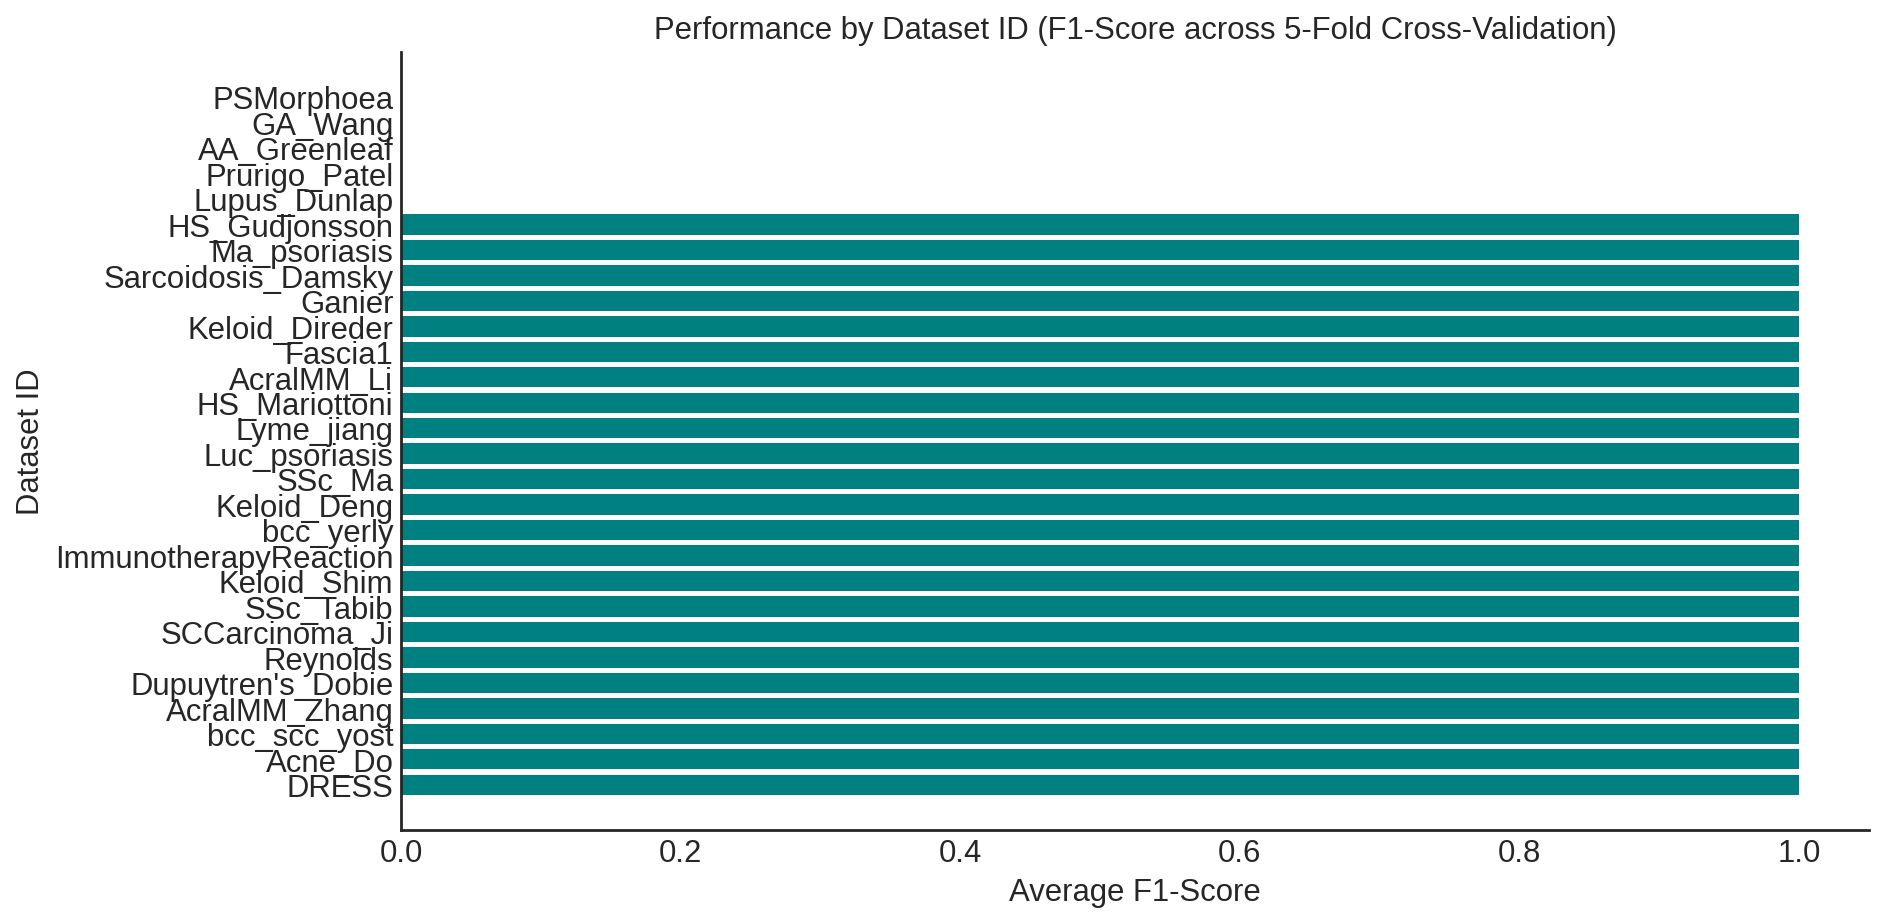

In [5]:
df = adata.obs[["scarring_risk", "dataset_id", "test13"]].copy()
cell_types = list(adata.obs["test13"].unique())

cell_type_proportions = pd.crosstab(df['dataset_id'], df['test13'], normalize='index')

for cell_type in cell_types:
    if cell_type not in cell_type_proportions.columns:
        cell_type_proportions[cell_type] = 0.0

df_encoded = df[['dataset_id', 'scarring_risk']].drop_duplicates()
df_encoded = df_encoded.merge(cell_type_proportions, left_on='dataset_id', right_index=True, how='left')

df_encoded["scarring_risk"] = df_encoded["scarring_risk"].astype('category').cat.codes
category_mapping = dict(enumerate(adata.obs["scarring_risk"].astype('category').cat.categories))

X = df_encoded.drop(columns=["dataset_id", "scarring_risk"])
y = df_encoded["scarring_risk"]
dataset_ids = df_encoded["dataset_id"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
dataset_performance = {}
disease_category_performance = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dataset_ids_train, dataset_ids_test = dataset_ids.iloc[train_index], dataset_ids.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_original = [category_mapping[i] for i in y_pred]
    y_test_original = [category_mapping[i] for i in y_test]

    for dataset_id in dataset_ids_test.unique():
        dataset_mask = dataset_ids_test == dataset_id
        y_test_dataset = y_test[dataset_mask]
        y_pred_dataset = y_pred[dataset_mask]

        y_test_dataset_original = [category_mapping[i] for i in y_test_dataset]
        y_pred_dataset_original = [category_mapping[i] for i in y_pred_dataset]

        report = classification_report(y_test_dataset_original, y_pred_dataset_original, output_dict=True)

        if dataset_id not in dataset_performance:
            dataset_performance[dataset_id] = {'f1': [], 'accuracy': []}

        dataset_performance[dataset_id]['f1'].append(report['macro avg']['f1-score'])
        dataset_performance[dataset_id]['accuracy'].append(report['accuracy'])

    for disease_cat in y_test.unique():
        disease_mask = y_test == disease_cat
        y_test_disease = y_test[disease_mask]
        y_pred_disease = y_pred[disease_mask]

        y_test_disease_original = [category_mapping[i] for i in y_test_disease]
        y_pred_disease_original = [category_mapping[i] for i in y_pred_disease]

        report = classification_report(y_test_disease_original, y_pred_disease_original, output_dict=True)

        if disease_cat not in disease_category_performance:
            disease_category_performance[disease_cat] = {'f1': [], 'accuracy': []}

        disease_category_performance[disease_cat]['f1'].append(report['macro avg']['f1-score'])
        disease_category_performance[disease_cat]['accuracy'].append(report['accuracy'])

dataset_f1_scores = {dataset_id: np.mean(performance['f1']) for dataset_id, performance in dataset_performance.items()}
disease_category_f1_scores = {disease_cat: np.mean(performance['f1']) for disease_cat, performance in disease_category_performance.items()}

dataset_f1_df = pd.DataFrame.from_dict(dataset_f1_scores, orient='index', columns=['Average F1-Score'])
dataset_f1_df.sort_values(by='Average F1-Score', ascending=False, inplace=True)

disease_category_f1_df = pd.DataFrame.from_dict(disease_category_f1_scores, orient='index', columns=['Average F1-Score'])
disease_category_f1_df.sort_values(by='Average F1-Score', ascending=False, inplace=True)

print("\nAverage Performance by Dataset ID (F1-Score across folds):")
print(dataset_f1_df)

print("\nAverage Performance by Disease Category (F1-Score across folds):")
print(disease_category_f1_df)

plt.figure(figsize=(12, 6))
plt.barh(dataset_f1_df.index, dataset_f1_df['Average F1-Score'], color='teal')
plt.xlabel("Average F1-Score")
plt.ylabel("Dataset ID")
plt.title("Performance by Dataset ID (F1-Score across 5-Fold Cross-Validation)")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.show()

risk_colors = {
    "Low risk": "#a9d18e",
    "Medium risk": "#f3b384",
    "Established fibrosis": "#C00000"   
}

disease_category_f1_df.index = disease_category_f1_df.index.map(category_mapping)
color_list = disease_category_f1_df.index.map(lambda x: risk_colors.get(x, "gray"))





# plt.figure(figsize=(12, 6))
# plt.barh(disease_category_f1_df.index, disease_category_f1_df['Average F1-Score'], color=color_list, edgecolor="black")
# plt.xlabel("Average F1 Score (5-Fold Cross-Validation)")
# plt.ylabel("Scarring risk group")
# plt.title("")
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.grid(Fals§e)
# plt.tight_layout()

# plt.savefig("sfig5/performance_classifier.pdf", dpi=300, bbox_inches="tight")  # Save as PDF with 300 DPI
# plt.show()



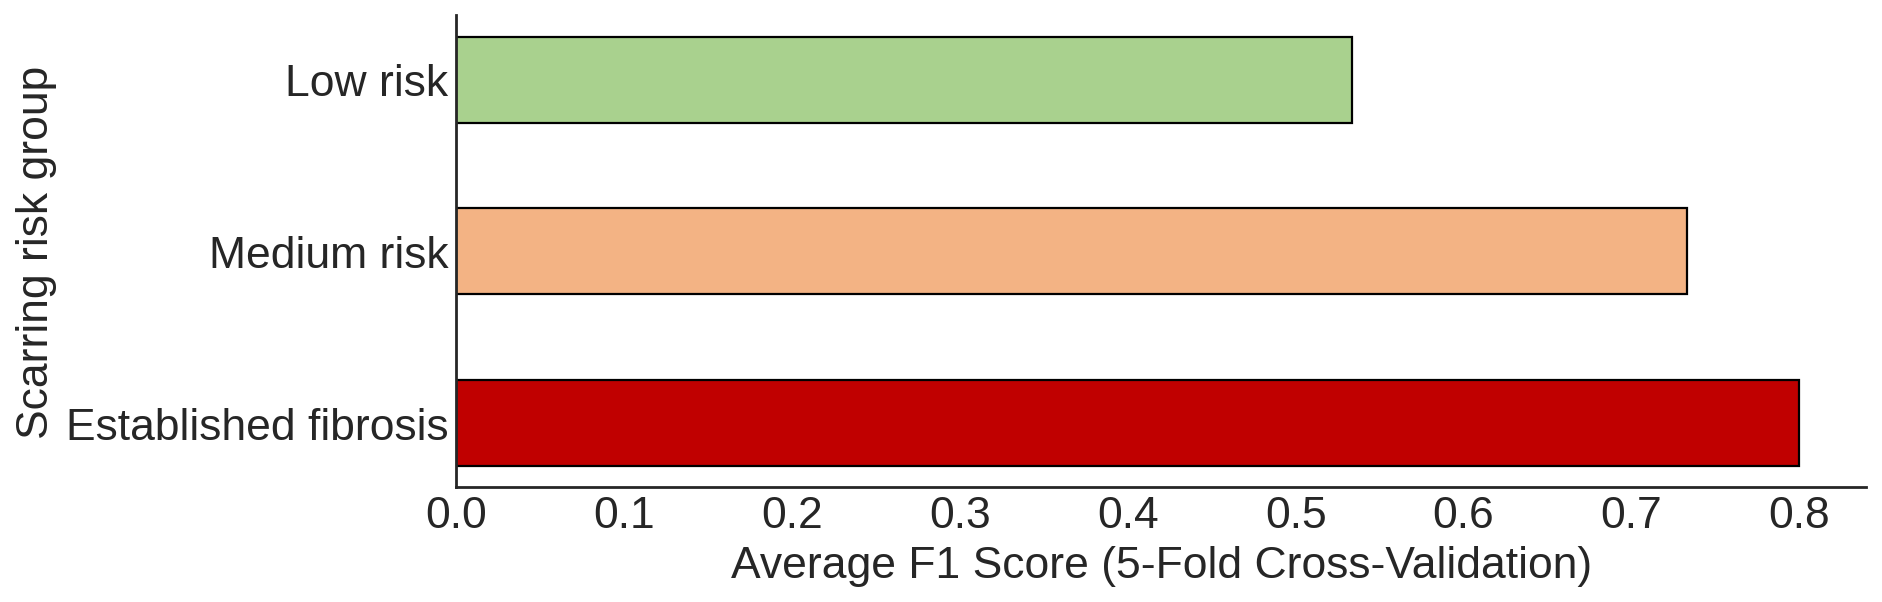

In [6]:
plt.figure(figsize=(12, 4))
plt.barh(disease_category_f1_df.index, disease_category_f1_df['Average F1-Score'], 
         color=color_list, edgecolor="black", height=0.5)  # Reduce height for thinner bars

plt.xlabel("Average F1 Score (5-Fold Cross-Validation)", fontsize=20)
plt.ylabel("Scarring risk group", fontsize=20)
plt.xticks(fontsize=20)  # Increase tick font size
plt.yticks(fontsize=20)
plt.title("", fontsize=22)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(False)

plt.tight_layout()
plt.savefig("sfig6/6b_performance_classifier.pdf", dpi=300, bbox_inches="tight")  # Save as PDF with 300 DPI
plt.show()



In [7]:
COLORS = {    'F1: Superficial': '#ffef5a',
    'F2/3: Perivascular': '#364f99',
    'F2: Universal': '#91bae2',
    'F3: FRC-like': '#c6508f',
    'F4: DP_HHIP+': '#c9efb4',
    'F4: DS_DPEP1+': '#3d6f3b',
    'F4: TNN+COCH+': '#00f273',
    'F5: NGFR+': '#8981a7',
    'F5: RAMP1+': '#4b2657',
     'F6: Inflammatory myofibroblast': "#75fbfd",
     'F7: Myofibroblast': "#2f6565",
       'F8: Fascia-like myofibroblast': '#dd7465',
 'F_Fascia': "#0000004D",
                               }

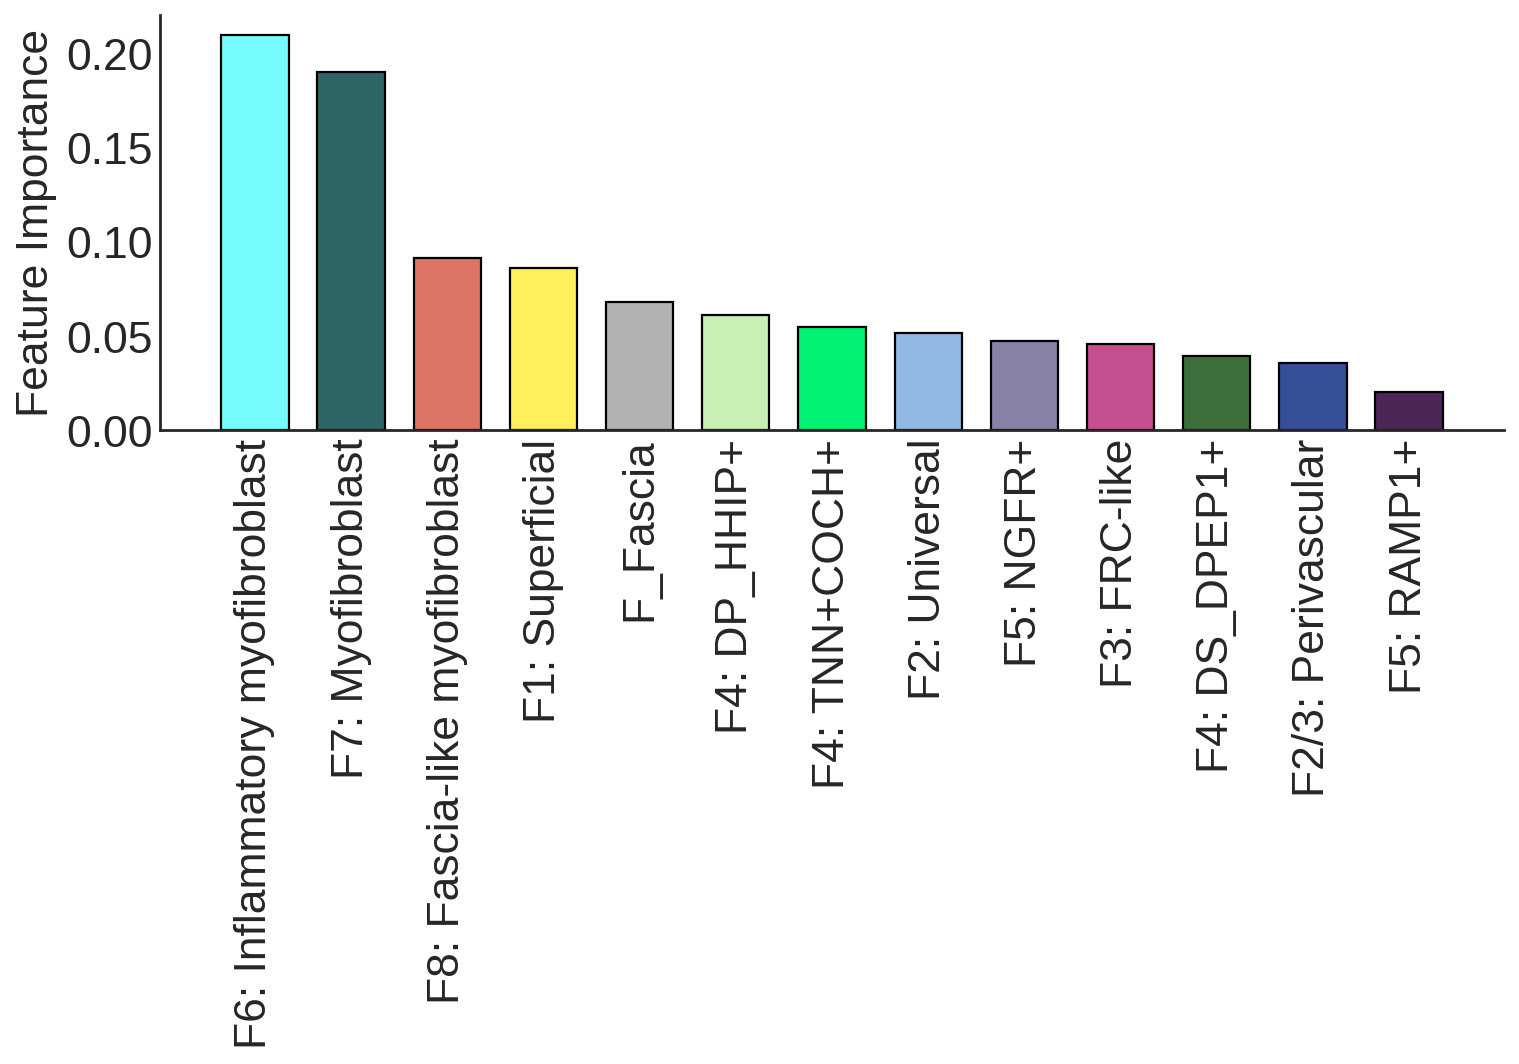

In [8]:
import numpy as np
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

color_mapping = [COLORS.get(cell_type, "#000000") for cell_type in X.columns[indices]]

plt.rcParams.update({'font.size': 18})   

plt.figure(figsize=(10, 7))   
plt.ylabel("Feature Importance", fontsize=20)  
plt.title("", fontsize=22)  
bars = plt.bar(range(X.shape[1]), importances[indices], align="center", color=color_mapping,
               edgecolor="black", width=0.7)

plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=20)  
plt.yticks(fontsize=20)  

ax = plt.gca()   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(False)  
plt.tight_layout()

plt.savefig("sfig6/6b_featureimportance.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
sc.logging.print_versions()


